In [1]:
# Students: ignore this code for now.  Used for testing only
use_answer_key = True
libHydroFile = "../python/libHydro.py"

# libHydro: A 1D Lagrangian hydrodynamics code

### From numpy and first principles to an ICF implosion in 100 lines of code.  You will learn to write your own 1D Lagrange hydro code in planar, cylindrical, and spherical coordinates on a staggered finite volume mesh.

## Equations of motion

A hydro code enforces the conservation of mass, momentum, and energy of a material; the Euler equations.  Enforcing this on a Lagrangian mesh, or one that follows the material motion, is simplified further.  We can write the coupled partial differential equations for this system using material derivatives (derivatives expressed in the Lagrangian frame of reference) as follows:

$$ \frac{D \rho}{D t} = -\rho \nabla\cdot \mathbf{ u} \ \ \ \text{(Mass)} $$

$$ \frac{D \mathbf{u} }{D t} = - \frac{ \nabla p}{ \rho} \ \ \ \text{(Momentum)} $$

$$  \frac{D e}{D t} = -\frac{p}{\rho} \nabla\cdot \mathbf{ u} \ \ \ \text{(Energy)} $$ 

## Finite Volume Lagrange

In the Lagrangian frame, we solve the discretized variables on a finite volume mesh; where thermodynamic variables are represented in the zone volume, while the velocities are given at the zone edges or nodes.

![title](img/FV_diagram.png)

We will be solving the above Euler equations for N zones and N+1 nodes. 

Nodal variables (blue circles):
- Velocity, $ u $
- Positions, $x$

Zonal variables (red X's):
- Density, $\rho$
- Energy, $e$
- Pressure, $p$

## Lagrangian motion

In addition to the Euler equations above, solving our system in a Lagrangian frame of reference requires that you evolve or move the mesh itself.  Since we have the velocity of nodes already through the momentum equation, we can simply integrate to get the change in node positions.  That is:

$$ \frac{d  \mathbf{ x}}{d t} =  \mathbf{ u} $$

## Equation of State

Note that we now have 4 EOM and 5 unknowns.  The Euler equations require a constitutive closure of thermodynamics variables, namely we'll require that there exists some explicit relationship for p as a function of density and energy.  That is we need to provide $p(\rho,e)$.  For the present development let us assume a gamma law gas, where $p = e(\gamma-1)/\rho$.  Future problems can include different EOS types and we will develop our solver to allow for any arbitrary relationship of the form:

$$ p(\rho,e) $$

## "F equals ma": A Newtonian way to see the Euler equations

There is another way of deriving and expressing the momentum equation of the Euler equations that is useful to acknowledge and discuss briefly.  Our ALE (Arbitrary Lagrangian-Eulerian) codes will often refer to RHS (right-hand-side) of the momentum equation as an "acceleration" because that's exactly what it is if you're a node.  If you solve the $F=ma$ for a node, you have $a = F/m$, where $F$ is really the sum of all the forces acting on a node.  In our simple Euler equations case, the forces are generated by a difference in pressure between the left and right of the node.

$$ a = \frac{\sum F} {m} \\a = \frac{(p_L - p_R)A}{m} \\
\frac{D u}{Dt} = \frac{(p_L - p_R)A}{\rho V} \\
\frac{D u}{Dt} = -\frac{(p_R - p_L)}{\rho \Delta x} \\
\frac{D u}{Dt} = -\frac{\nabla p}{\rho} \\ $$

The result of expanding $F=ma$ is the same momentum equation.  When we solve for acceleration in out finite volume scheme, this connection will become even more apparent.

## Integral form

The PDEs above are written in the strong integral form, where they are enforced explicitly over a volume, $V$ as:

$$ \int_V \frac{D u}{Dt} dV = - \frac{1}{\rho}\int_V \nabla p \ dV $$

which can then be re-written using the divergence theorem as a surface integral as:

$$ \frac{D u}{Dt} V = - \frac{1}{\rho}\int_A p\mathbf{n} \ dA $$.

If we now rearrange and expand out the surface integral we have:

$$ \frac{D u}{Dt} = - \frac{A}{\rho V} \sum_f p_f n_f  = - \frac{A}{m_N}\left( p_R - p_L  \right)$$.

This surface integral equation can be solved discretely over our finite volume zones.  Since these volumes are 1D, the only surfaces to consider are the left and right states.  The normal vector into/out of the cell will give alternating signs for the pressure values.  The same approach is followed for the energy equations.

## Discrete Evolution equations

Now that we have all the equations of motion defined, we can write down a candidate time integration scheme that will be employed to advance the variables in time.  (We say candidate because we can/will explore more complicated time advancement schemes that yield higher order accuracy and better numerical stability.)



1st order in time update scheme:

1) Solve for nodal acceleration, $a$

$$ a_{n_i}^t=\frac{A_{n_i}^t}{m_{n_i}}(p_{z,L\in n_i}^t - p_{z,R\in n_i}^t) $$

2) Update nodal velocities and positions using forward Euler method

$$ u_{n_i}^{t+1} = u_{n_i}^{t} + \Delta t  a_{n_i}^t $$
$$ x_{n_i}^{t+1} = x_{n_i}^{t} + \Delta t  u_{n_i}^{t+1} $$


3) Update zone volumes and densities.

$$ V_{z}^{t+1} = F(x_{n}^{t+1}) \\ 
A_{n}^{t+1} = G(x_{n}^{t+1}) \\ 
\rho^{t+1}_{z_j} =  m_{z_j} / V_{z_j}^{t+1} $$

4) Solve for zonal PdV work.

$$ w_{z_j}^t = \frac{p^t_{z_j}}{m_{z_j}}((uA)_{n,L\in z_j}^{t+1} - (uA)_{n,R\in z_j}^{t+1} ) $$

5) Update energy equation.

$$ e_{z_j}^{t+1} = e_{z_j}^{t} + \Delta t  w_{z_j}^t $$

6) Update pressure via EOS.

$$ p^{t+1}_{z_j} = EOS(\rho^{t+1}_{z_j}, e_{z_j}^{t+1} ) $$

## libHydro's 3 core functions... as easy as 1, 2, 3

Step 1-6 above constitute one step of the hydro evolution equation.  Some of these steps are trivial, as both the RHS and LHS are operations on the same mesh locality paradigm; either nodes or zones.  For example,  step 2 operates and depends only on nodal quantities $(a,u,x)$ and this can be trivially performed on data arrays.  The same is true of steps 5 and 6, though now we are operating on zonal quantities. 

Difficulties arise when nodals require zonals values and visa-versa.  For these steps, we will write routines/functions that will perform these operations.  The first such routine will compute the nodal acceleration, $a_{n_i}^t$.

### A note on the Data arrrays

At this stage, we'll need to assume nodal and zonal values have been discretized and are stored in an array.  Let us assume that nodal arrays have length $n+1$ and zonal arrays have length $n$.  Further, assume that the data are easily accessed through a dictionary called "hydro_state" by the variable name.  A template for the computing the nodal acceleration might be:

In [2]:
def updateAccelerationExample(hydro_state):
    pressure = hydro_state["p"]      # Get pressure (zonal)
    area     = hydro_state["Farea"]  # Get face area (nodal)
    mass     = hydro_state["Nmass"]  # Get mass (nodal)

    # Compute nodal acceleration, acc
    n = mass.shape[0]
    acc = np.zeros(n)
    for i in range(n):
        acc[i] = ...

    # Update acceleration in hydro_state 
    hydro_state['acc'] = acc

Note the calculation of acceleration (`acc`) at each node (`n`) will require the the usage of two pressure values ($p_L$ and $p_R$) in the zones to the left and right of the node, $n$.  You will need to write a loop what accesses those pressures and uses them as written above.

Likewise, you will need to write routines for step 3 and 4 namely:

`updateVolume(hydro_state)`  - Compute volumes and areas by using new nodal positions; update `hydro_state` values

`updateWork(hydro_state)` - Compute the PdV work term in the energy equation; update `hydro_state` values

The rest of equations (including the EOS) can be easily written when we write the integration code (steps 1-6) itself.

An aside on naming: Our libHydro code uses the same or similar variable names to Ares, so learning variables here will help you there, too!


### Exercise 1:  Write a bare-bones libHydro.py
Create a libHydro core routines by starting with the code below:
Note that we have already added some simple template code to make the hydro variables and compute the mass at each zone and at each node.

First we'll need to bring in a module called libCommon that helps set up our super simple data structures:

In [3]:
import numpy as np
import sys

# Load common functions; makeMeshVariables, etc
exec(open("../../libCommon/python/libCommon.py").read())

Existing routines are:
- `setupHydroState()` (given below)
- `updateMass()` (given below)

To complete the initial hydro library, add the following routines:
- `updateVolume()`
- `updateAcceleration()` - for now, assumed the first and last nodes have zero acceleration
- `updateWork()`


### Given functions

In [4]:
def setupHydroState(Nzones):
    """
    inputs:
      Nzones - total number of zones in domain
    returns:
      hydro_state - a dictionary with the hydro state nodals/zonals
    """
    # List of variables; Nodal and Zonal
    zonals = ['p','den','e','vol','dx','xz','Zmass','q','cs2','mat','work']
    nodals = ['x','xdot','Nmass','Farea','acc']
    hydro_state = makeMeshVariables(Nzones,zonals,nodals)
    return hydro_state

def updateMass(hydro_state):
    """
    inputs:
      hd   - hydro state
    returns:
      None - hydro state updated
    """
    hydro_state['Zmass']       = hydro_state['vol'] * hydro_state['den']
    hydro_state['Nmass'][1:-1] = ( hydro_state['Zmass'][:-1] + hydro_state['Zmass'][1:]  ) / 2.0
    hydro_state['Nmass'][0]    = hydro_state['Zmass'][0]  / 2.0
    hydro_state['Nmass'][-1]   = hydro_state['Zmass'][-1] / 2.0
    return None

### Complete these functions for libHydro

In [5]:
def updateVolume(hydro_state):
    """
    Note: Assume unity area s.t. vol = dx
    inputs:
      hydro_state - a dictionary with the hydro state nodals/zonals
    outputs:
      None        - hydro state volume terms updated
    """
    hydro_state['dx']  = np.diff( hydro_state['x'] )                         # X (or R) spacing
    hydro_state['xz']  = hydro_state['dx']/2.0 + hydro_state['x'][:-1]                 # Zone centered coordinate
    ...
    ...
    hydro_state['Farea'] = ...
    hydro_state['vol'] = ...
    return None
    
def updateAcceleration(hydro_state):
    """
    inputs:
      hydro_state - a dictionary with the hydro state nodals/zonals
    outputs:
      None        - hydro state 'acc' (nodal acceleration values) updated
    """
    ...
    ...
    hydro_state['acc'] = ...
    return None

def updateWork(hydro_state):
    """
    inputs:
      hydro_state - a dictionary with the hydro state nodals/zonals
    outputs:
      None        - hydro state work (nodal values for pdV work term) updated
    """
    ...
    ...
    hydro_state['work'] = ...
    return None

In [6]:
# Students: ignore this code for now.  Used for testing only
if use_answer_key:
    exec(open(libHydroFile).read())

### Excercise 2: Verification check on a 2 zone (3 node)

At this stage, it's always good to run a very simple, closed-form-solution test of the routines we just wrote.
This routine will check the `updateVolume` and `updateAcceleration` functions.  Go through each test and verify that the output gives the same expected result.  This result can be worked out on paper but is given in the comments below.

In [7]:
# Initial setup, mesh, and Check Volume
hydro_state = setupHydroState(2)   # Setup the data
hydro_state['x'][:] = [0,.5,1.0]   # Setup the mesh
updateVolume(hydro_state)          # Compute zone volumes
print(hydro_state['vol'])          # This should give [0.5, 0.5]

[0.5 0.5]


In [8]:
# Initial conditions
hydro_state['den'][:] =  [1.0 , 1.0]  # Left and right densities
hydro_state['p'][:]   =  [2.0 , 1.0]  # Left and right pressures
updateMass(hydro_state)               # Compute the nodal/zonal mass
print(hydro_state['Nmass'])           # This should be [0.25,0.5,0.25]
print(hydro_state['Zmass'])           # This should be [0.5, 0.5]

[0.25 0.5  0.25]
[0.5 0.5]


In [9]:
# Check Acceleration
updateAcceleration(hydro_state)         # Compute nodal accelerations
print(hydro_state['acc'])               # This should be [0., 2., 0.]

[0. 2. 0.]


In [10]:
# Check work
hydro_state['xdot'][:] = [0.0, 1.0, 0.0]  # Set velocity gradients
updateWork(hydro_state)                   # Get PdV work term
print(hydro_state['work'])                # This should be [-4., 2.]

[-4.  2.]


### Excercise 3: Quiescient and constant flow

We now write a test problem that integrates the equations through time for a set of trivial and boring initial conditions.  So here we will be solving steps 1-6 as outlined above.

Let's start again with the same 2 zone problem but with constant initial conditions and zero velocity.

#### Quiescient Flow

In [11]:
# Initial setup, mesh, and initial conditions
hydro_state = setupHydroState(2)       # Setup the data
hydro_state['x'][:]   =  [0, .5, 1.0]  # Setup the mesh
hydro_state['xdot'][:]=  [0,  0,   0]  # No flow
hydro_state['den'][:] =  [1.0 , 1.0]   # Left and right densities
hydro_state['p'][:]   =  [1.0 , 1.0]   # Left and right pressures
hydro_state['e'][:]   =  [1.0 , 1.0]   # Left and right energies

updateVolume(hydro_state)              # Compute zone volumes
updateMass(hydro_state)                # Compute the nodal/zonal mass

### Add in an analytical Equation of State

We also need an equation of state (EOS) now, to give us pressure as a function of density and energy.  For this, let us use a simple algebraic formula, $p = \rho e$, and make it a function that depends on our hydro state dictionary.  We then can simply add it to our state as a new dictionary item.  

The expectation is that calling the eos function this way, ``eos(hydro_state)`` will update the pressure as a function of the other thermodynamic states.  We'll leave this function general in this way which will allow you to add in more interesting functions in the future.


In [12]:
# Trivial EOS updates pressure
def eos(hd):
    '''Trivial EOS function'''
    hd['p'] = hd['e'] * hd['den']
    
# Add eos function to the hydro_state dictionary.
hydro_state['eos'] = eos

### Write a hydroStep function to advance to solution one timestep

In [13]:
# Put all 6 steps in a routine
def hydroStep(dt, hydro_state):
    
    # Step 1
    updateAcceleration(hydro_state)

    # Step 2
    hydro_state['xdot'] += ...
    hydro_state['x']    += ...

    # Step 3
    updateVolume(hydro_state)
    hydro_state['den'] = ...

    # Step 4
    updateWork(hydro_state)

    # Step 5
    hydro_state['e'] += ...

    # Step 6 - a fake EOS
    eos = hydro_state['eos']
    eos(hydro_state)

In [14]:
# Students: ignore this code for now.  Used for testing only
if use_answer_key:
    exec(open("../python/libHydro_partialsolutions.py").read())
    hydroStep = hydroStep_v1

In [15]:
# Take a step
dt = 0.01
hydroStep(dt, hydro_state)

In [16]:
# Verify no changes occured in thermodynamic variables
print(hydro_state['p'][:])   # Should be [1., 1.]
print(hydro_state['x'][:])   # Should be [0., 0.5, 1.]

[1. 1.]
[0.  0.5 1. ]


#### Constant Flow
We now repeat the same problem but with constant velocity of 1.0 at all nodes

In [17]:
# Initial setup, mesh, and initial conditions
hydro_state = setupHydroState(2)        # Setup the data
hydro_state['x'][:]    =  [0, .5, 1.0]  # Setup the mesh
hydro_state['xdot'][:] =  [1,  1,   1]  # Constant flow
hydro_state['den'][:]  =  [1.0 , 1.0]   # Left and right densities
hydro_state['p'][:]    =  [1.0 , 1.0]   # Left and right pressures
hydro_state['e'][:]    =  [1.0 , 1.0]   # Left and right energies
hydro_state['eos']     =  eos           # EOS function

updateVolume(hydro_state)               # Compute zone volumes
updateMass(hydro_state)                 # Compute the nodal/zonal mass

dt = 0.01                               # Timestep size

# Take a step
hydroStep(dt, hydro_state)

In [18]:
# Verify no changes occured in thermodynamic variables and only in mesh
print(hydro_state['p'][:])   # Should be [1., 1.]
print(hydro_state['x'][:])   # Should be [0.01, 0.51, 1.01]

[1. 1.]
[0.01 0.51 1.01]


## Exercise 4:  SOD shock tube validation of libHydro

We will now attempt to solve the non-trivial time-dependent solution of the Euler equations for the canonical SOD shock tube problem.  We'll assume a gamma-law gas EOS with a gamma of 1.4.

This problem is defined here but we'll repeat the initial conditions $(\rho, p, xdot)$ given by 2 states, left and right as shown in the following diagram:

![title](img/SOD_diagram.png)


In our python code, we can easily implement these initial conditions for the conserved quantities as:

In [19]:
# SOD initial conditions
N = 100
hydro_state = setupHydroState(N)       # Setup the data
half = int(N/2.0)                      # Half the domain
gamma = 1.4                            # Ratio of specific heats for an ideal gas

# Set left state
hydro_state['den'][:]        = 1.0
hydro_state['e'][:]          = 1.0 / 1.0 / (gamma-1.0)

# Set right state
hydro_state['den'][half:]    = 0.125
hydro_state['e'][half:]      = .1 / .125 / (gamma-1.0)


With this more realistic problem, we'll also need to set a realistic equation of state (EOS).  For this we write our own function here and use it in the hydro step function.  Recall, in general we need $p = f(e,\rho)$.  For a gamma-law gas this simple EOS can be written as:

In [20]:
def eos(hd):
    '''Simple gamma-law gas EOS
    Note, this is implicitly capturing the global variable gamma'''
    hd['p'] = hd['e'] * hd['den'] * (gamma - 1.0)

hydro_state['eos'] = eos

# Set pressure via EOS
eos( hydro_state )

# Initialize the mesh and volumes 
hydro_state['x']   = np.linspace(0,1.0,N+1)
updateVolume(hydro_state)
updateMass(hydro_state)


### Evolve the initial conditions with a constant timestep

With our initial conditions and EOS defined, we can now repeatedly call the `hydroStep` routine to advance the equations in time.  Run the state out to `t=0.2` using a constant timestep of `dt=5e-5`.

In [21]:
# Simple while loop to advance solution to 0.2
t = 0.0
dt = 1.0e-5
while t < 0.2:
    hydroStep(dt, hydro_state)
    t += dt

#### Load in the analytical solution for comparison and plot Lagrange solution

In [22]:
import matplotlib.pyplot as plt

# Compare to analytical solution
sod_solution = np.loadtxt("misc/sod0.txt")
x_sol   = sod_solution[:,0]
u_sol   = sod_solution[:,1]
rho_sol = sod_solution[:,2]
p_sol   = sod_solution[:,3]



# Plot simulation vs. analytical results
xz  = hydro_state['xz']
plt.plot( xz, hydro_state['p'],'b-',label='Pressure')
plt.plot(x_sol,p_sol,'k--',label="Reference")
plt.legend()
plt.xlabel('x')
plt.title("Pressure at t=0.2")
plt.show()


<Figure size 640x480 with 1 Axes>

## What went wrong?: Shocks and "q"

Note the comparison between the numerical solution and the analytical solution in the expansion region $x\in(.2,.5)$ is quite reasonable while the shock region (at $x=0.85$) has developed horrible numerical instabilities.  These instabilities arise from our attempt to discretize and solve a PDE which has become singular at the shock.  The numerics get themselves into a feedback loop and Gibbs oscillations and numerical instability corrupt the solution beyond repair.  


#### Von Neumann
This was observed and a remedy was proposed by Jon Von Neumann and R. Richtmyer in 1950 ([see their paper](misc/JVN_q.pdf)). Von Neumann proposed that the shock could be regularized or made resolvable on the discretized mesh by the addition of artificial viscosity, which was given the variable "q" in his paper.  Entire careers have been made on shock regularization and shock capturing but we will keep things simple and pure and implement the originally proposed method of Von Neumann.  At the National Labs, the "q" name stuck around and we still to this day refer to artificial viscosity as "q".

Directly from his paper, we have "q" defined as:

![title](img/q_equation.png)


Re-writing the above in terms and variables that have been using above we have:

$$
q = -\rho(c\Delta x)^2\frac{\partial u}{\partial x}\left| \frac{\partial u}{\partial x}\right|
$$
	

were $c$ is some unitless constant.  Since $q$ acts like a diffusive pressure, $q$ then enters our equations of motion the same way that pressure does.  

This above form is one form of shock capturing, artificial viscosity, or hyperviscosity; there are many names and even more forms to this equation.  The efficacy of each form depends on the underlying numerical method and many PhDs have been devoted to studying this topic.  For brevity, we introduce only one other form for $q$ proposed by John Castor in his seminal book, [Radiation Shock Dynamics.](https://digital.library.unt.edu/ark:/67531/metadc879997/m2/1/high_res_d/898010.pdf)

From the book, we have:

![title](img/Castor_q.png)

which is nearly equivalent to Von Neumann's $q$ except that Castor has efectively turned-off $q$ when the flow is in an expansion or when $\partial u / \partial x > 0$.  For the present coursework, we propose the following form which takes from both previous forms:

$$
q = -C_u\rho\Delta x^2 \frac{\partial u}{\partial x}\left| \frac{\partial u}{\partial x}\right| \\
C_u = 8.0
\begin{cases}
    1.0,           &   \partial u / \partial x < 0 \\
    0.05,          &   \partial u / \partial x >= 0
\end{cases} 
$$


We can modify `updateAcceleration` and `updateWork` in our libHydro equations to include this additional term.

Note, we will also need to implement an `updateQ` routine into libHydro.  The reader will notice that the equation for $q$ depends on nodal and zonal quantities so care is required in computing these values.  $q$ itself is a zonal as it will be added like a pressure.

### A note on $du/dx$

We need to compute $du/dx$ on each zone in order to form $q$ above.  All other variables in the equation are already zonal quantities, but $u$ is a nodal so we need to compute its divergence before we can form $q$.  Like before, lets use our volume integral approach again:

$$
\int_V \frac{\partial u}{\partial x}|_z dV = \int_V \left(\nabla\cdot\vec{u}\right) dV \\
\frac{\partial u}{\partial x}|_z  = \frac{1}{V} \int_A u dA \\
\frac{\partial u}{\partial x}|_z  = \frac{1}{V} \left( (Au)_R - (Au)_L \right)
$$

The full expression for $du/dx$ expressed in the same syntax as the hydro algorithm above is:

$$
     \frac{du}{dx}|_{z_j}^t = \frac{1}{V_{z_j}^t}((uA)_{n,R\in z_j}^{t} - (uA)_{n,L\in z_j}^{t} )
$$




## Excercise 5: Add in "q" equation, update libHydro, and re-run Sod

Complete the equation below to compute Q and add q to the pressure in acceleration and work.


In [23]:
def updateQ(hd):
    """
    inputs:
      hd   - hydro state
    return:
      None - hydro state q (zonal based artificial viscosity [pressure units]) updated
    """
    p    = hd['p']
    den  = hd['den']
    ...
    ...
    hd['q'] = ...
    return None
    
    
def updateAcceleration(hd):
    """
    inputs:
      hd   - hydro state
    returns:
      None - hydro state acc (nodal based acceleration [L/T^2]) updated
    """
    
    # Some local working variables
    p    = hd['p'] + hd['q']
    ...
    acc = ...
    
    hydro_state['acc'] = acc
    
    return None


def updateWork(hd):
    """
    inputs:
      hd   - hydro state
    returns:
      None - hydro state work (zonal based pressure work term... F*dV) updated
    """
    p    = hd['p'] + hd['q']
    ...
    ...
    work = ...
    
    hydro_state['work'] = work
    
    return None

# Put all 6 steps in a routine
def hydroStep(dt, hydro_state):
    
    updateQ(hydro_state)
    ...
    # Step 1 
    # Step 2
    # Step 3
    # Step 4
    # Step 5
    # Step 6 - EOS
    ...
    

In [24]:
# Students: ignore this code for now.  Used for testing only
if use_answer_key:
    exec(open(libHydroFile).read())
    try:  # Load in partial solutions for demo - wont work for students
        exec(open("../python/libHydro_partialsolutions.py").read())
        hydroStep = hydroStep_Q
    except:
        pass

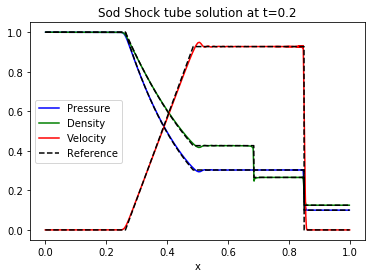

In [25]:
# SOD initial conditions, now with 200 pts
N = 500
hydro_state = setupHydroState(N)       # Setup the data
half = int(N/2.0)                      # Half the domain
gamma = 1.4                            # Ratio of specific heats for an ideal gas

# Set left state
hydro_state['den'][:]        = 1.0
hydro_state['e'][:]          = 1.0 / 1.0 / (gamma-1.0)

# Set right state
hydro_state['den'][half:]    = 0.125
hydro_state['e'][half:]      = .1 / .125 / (gamma-1.0)

# Set pressure via EOS and the EOS
eos(hydro_state)
hydro_state['eos'] = eos


# Initialize the mesh and volumes 
hydro_state['x']   = np.linspace(0,1.0,N+1)
updateVolume(hydro_state)
updateMass(hydro_state)


# Simple while loop to advance solution to 0.2
t = 0.0
dt = 1.0e-5
while t < 0.2:
    hydroStep(dt, hydro_state)
    t += dt
    
    
import matplotlib.pyplot as plt
xn  = hydro_state['x']
xz  = hydro_state['xz']
plt.plot( xz, hydro_state['p'],'b-', label='Pressure')
plt.plot( xz, hydro_state['den'],'g-', label="Density")
plt.plot( xn, hydro_state['xdot'],'r-', label="Velocity")
plt.plot(x_sol,p_sol,'k--',label="Reference")
plt.plot(x_sol,u_sol,'k--')
plt.plot(x_sol,rho_sol,'k--')
plt.xlabel('x')
plt.title("Sod Shock tube solution at t=0.2")
plt.legend()
plt.show()  


With the addition of $q$ we have nearly completely eliminated the oscillations near the shock.  As with nearly all shock capturing methods, the errors are largest and localized near the shocks or discontinuities.  These errors tend to be 1$^{st}$ order in space, meaning they vanish at the same rate as the grid spacing is reduced.

## Geometric effects: Cylindrical and Spherical geometries


So far, we've written our code to solve hydro problems that assume a 1D planar or slab geometry.  However, there are many problems of interest (if not most) that require either cylindrical or spherical geometries.  These are still "1D" problems, in that there is only 1 direction in space with dependence over which we will solve.  However, in both cylindrical and spherical, this direction is "r" or the radial position in a flow domain that is either described by a cylinder or a sphere (see below):


![title](img/axisymmetric_flow1.jpg)
<h3 align="center">Figure: (Above) Example of cylindrical flow</h3> 

![title](img/spherical-ICF-target.jpg)
<h3 align="center">Figure: (Above) Example of spherical flow</h3> 

#### Finite Volume geometries
To see how the different geometries might impact our solution, we first take a look at our finite volume discretization and the elements that might make up these geometries:

![title](img/FV_cyl.png)
<h3 align="center">Figure: (Above) Example of cylindrical finite volume</h3> 

![title](img/FV_sph.png)
<h3 align="center">Figure: (Above) Example of spherical finite volume</h3> 

Note, that the volumes of the zones (red "x"'s) and the areas of the faces (blue circles) are now dependent on the absolute coordinate, in this case "r".  That is, zones to the right of the diagram have larger volumes than the ones on the left.   The areas and volumes will increase linearly with "r" for cylindrical coordinates, and with "r"^2 for spherical coordinates.

In order to support these geometries, we need to modify our routine for calculating zone volumes and face areas.  Amazingly, this is the only place in our hydro solver where we will need to specify any geometry dependent code!

## Exercise 6: Verify volume and face area equations and add to `updateVolume`

We introduce a new parameter `geom` to distinguish betweem planar, cylindrical, and spherical coordinates.
For `geom` = 0, 1, 2, write out the equations for Volume and face area:

- Planar, `geom=0`:
    - Volume: $\Delta  x$
    - Area: 1.0
- Cylindrical, `geom=1`:
    - Volume: $2 \pi \, r_z \, \Delta x$
    - Area: $2 \pi \, r_n$
- Spherical, `geom=2`:
    - Volume: $4 \pi \, r_z^2 \, \Delta x$
    - Area: $4 \pi \, r_n^2$

Note: The above convention gives volumes per unit area (planar geometry), volume per unit length (cylindrical geometry) and total volume (spherical geometry).

Note: We can avoid the use of zonal radii in our volume equations by deriving exact expressions that use nodal radii only.



In [26]:
def updateVolume(hd):
    """
    inputs:
      hd   - hydro state created in setup_hydro
    returns:
      hd   - hydro state is updated
    """
    geom = hd.get('geom', 0)                                # 0-planar(def), 1-cylindrical, 2-spherical
    hd['dx']  = np.diff( hd['x'] )                          # X (radial) spacing
    hd['xz'] = hd['dx']/2.0 + hd['x'][:-1]                  # Zone centered coordinate
    hd['vol'] = ...                                         # Volume of the zone
    hd['Farea'] = ...                                       # Face area

In [27]:
# Students: ignore this code for now.  Used for testing only
if use_answer_key:
    exec(open(libHydroFile).read())
    try:  # Load in partial solutions for demo - wont work for students
        exec(open("../python/libHydro_partialsolutions.py").read())
        hydroStep = hydroStep_geom
    except:
        pass

### Verify volumes and areas on 2 zone problem

In [28]:
# Initial setup, mesh, and Check Volume
for geom in [0,1,2]:
    hydro_state = setupHydroState(2)   # Setup the data
    hydro_state['x'][:] = [0,.5,1.0]   # Setup the mesh
    hydro_state['geom'] = geom
    
    updateVolume(hydro_state)   # Compute zone volumes
    print(("geom-%s  " % geom) + str(hydro_state['vol']))           # This should give [0.5 0.5]
    
print("""
Should be:

geom-0  [0.5 0.5]
geom-1  [0.78539816 2.35619449]
geom-2  [0.52359878 3.66519143]

""")
    

geom-0  [0.5 0.5]
geom-1  [0.78539816 2.35619449]
geom-2  [0.52359878 3.66519143]

Should be:

geom-0  [0.5 0.5]
geom-1  [0.78539816 2.35619449]
geom-2  [0.52359878 3.66519143]




## Exercise 7:  Sedov-Taylor blast wave in planar geometry

Equipped with our new-found ability to handle shock waves, and different geometries, we'll now test our solver out on one of the most ubiquitous and difficult problems in hydrodynamics, the Sedov blast wave.  Why is the Sedov blast wave so hard?  Because the problem starts with a singularity and becomes a self-similarly propagating shock wave.  This problem and its analytical solutions were used to infer the yield of a nuclear explosion given the shock wave speed/Mach number measured at different radii.  It also has solutions in planar, cylindrical, and spherical geometries.  We will test our solver in all three.

The Sedov blast wave is defined as:

- Domain: $0 < x < 1$, $0.0 < t < 0.5$
    - `N = 200`,  `dt = 3.0e-5`
- Initial conditions:
    - $\rho = 1.0$ for all $x$
    - $p = 0.0$ for all $x$
    - $u = 0.0$ for all $x$
- Blast energy:
    - $e(z_{i=0}) = 1.0$ / $\Delta V_{z{i=0}}$
- Gamma-law gas:
    - $\gamma = 1.4$

Plot p, u, rho vs. x at t=0.5.



In [29]:
N  = 200       # Nzones
x0 = 0         # Left node location
x1 = 1         # Right node location
gamma = 1.4    # Gas constant

# Sedov
tf   = 0.5
dt   = 1.0e-5
etot = 1.0
CFL = .05

def eos(hd):
    '''Simple gamma-law gas
    Note, this is implicitly capturing the global variable gamma
    '''
    hd['p']   = hd['e'] * hd['den'] * (gamma-1.0)
    hd['cs2'] = hd['p'] / hd['den'] * gamma
    
def sedov(geom):

    # Setup 1D data
    hydro_state = setupHydroState(N)

    # Initialize the mesh and volumes 
    hydro_state['geom'] = geom
    hydro_state['x']   = np.linspace(x0,x1,N+1)
    updateVolume(hydro_state)

    # Set hydro state
    hydro_state['den'][:]  = 1.0
    updateVolume(hydro_state)
    hydro_state['e'][:] = 0.0
    
    # Point energy source
    hydro_state['e'][0] = etot / hydro_state['vol'][0]

    # Get pressure and masses
    hydro_state['eos'] = eos
    eos( hydro_state )
    updateMass(hydro_state)

    # Physics Loop
    time = 0.0
    while time < tf:
        
        # Adaptive time steps
        xdot = hydro_state['xdot']
        cs = np.sqrt( np.abs( hydro_state['cs2'] )  )
        dt = CFL * np.min( hydro_state['dx'] / ( np.abs(xdot[1:] ) + cs + 1.0e-10 ) )
        hydroStep(dt, hydro_state)
        time += dt
            

    # Compare solutions to analytical
    xn  = hydro_state['x']
    xz  = hydro_state['xz']
    plt.plot( xz , hydro_state['p']      ,'b.-', label="Pressure")
    plt.plot( xz , hydro_state['den']    ,'g.-', label="Density")
    plt.plot( xn , hydro_state['xdot']   ,'r.-', label="Velocity")
 
    # Reference
    sod_solution = np.loadtxt("misc/sedov%s.txt" % geom)
    x   = sod_solution[:,0]
    u   = sod_solution[:,1]
    rho = sod_solution[:,2]
    p   = sod_solution[:,3]
        
    plt.plot(x,p,'k--',label="Reference")
    plt.plot(x,u,'k--')
    plt.plot(x,rho,'k--')
    plt.xlabel('x')
    plt.title("Sedov solution at t=0.5, geom=%s" % geom)
    plt.legend()
    plt.show()  
    plt.show()

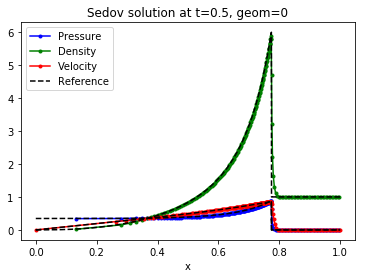

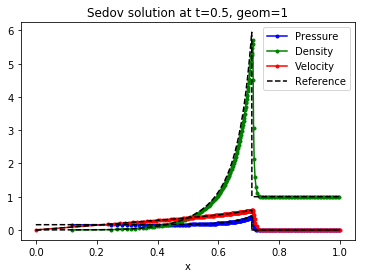

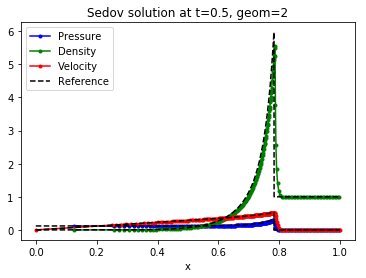

In [30]:
# Run through all the geometries
for g in [0,1,2]:
    sedov(g)

## Exercise 8: Multi-material NIF implosion test problem

We now will introduce a problem which uses multiple species, material, or EOS forms for each zone.  All zones will continue to have energy, density, volume, and all nodes will have velocity and position.  However, we now allow the constituitive EOS to vary for each zone.  This will determine the zone's pressure as a function of density and energy.  No additional routines are required in libHydro.py as we can handle this dependence directly when we write our EOS functions.

For this NIF implosion test problem, we solve a 3 material problem with gases all obeying a gamma law gas EOS but with varying values for gamma.  See the diagram below:


![title](img/nif_diagram.png)
<h3 align="center">Figure: (Above) Diagram of simple NIF implosion test problem</h3> 


To create the grid for this problem, we can simply add 3 domains together, each with the discretization given in the diagram.


In [31]:
geom = 2

nz_gas = 100
nz_ch  = 50
nz_dr  = 50
 
L_gas  = .1
L_ch   = L_gas + .01
L_dr   = L_ch  + .04
 
# Setup 1D data
N = nz_gas + nz_ch + nz_dr
hydro_state = setupHydroState(N)
 
x_gas = np.linspace(0     , L_gas, nz_gas+1 )[:-1]
x_ch  = np.linspace(L_gas , L_ch , nz_ch +1 )[:-1]
x_dr  = np.linspace(L_ch  , L_dr , nz_dr +1 )

# Initialize the mesh and volumes 
hydro_state['geom'] = geom
hydro_state['x'][:] = np.concatenate( (x_gas,x_ch,x_dr) )
updateVolume(hydro_state)


Each zone will have a unique set of constitutive properties that will remain the same for the entire calculation.  For convenience, we can introduce "slices" in numpy (which are basically nodelists in Ares) to more easily interact with values in each of the 3 materials.  The code below shows how these lists can be used to build up a global zonal array that contains the properties needed to evaluate the EOS.  Our gamma-law gas EOS now depends on the gamma in each zone as well as the reference density in each zone.  Note, "gamma_tot" and "rho_tot" are constant in each zone for all time.

In [32]:
# Define 3 EOS's
rho_gas =  0.1
rho_ch  = 10.0
rho_dr  = 1.0
 
gamma_gas = 1.1
gamma_ch  = 2.0
gamma_dr  = 1.8
 
# Make material slices (like nodelists)
sl_gas = np.s_[:nz_gas]
sl_ch  = np.s_[nz_gas:nz_gas+nz_ch]
sl_dr  = np.s_[nz_gas+nz_ch:N]
sl_drN = np.s_[nz_gas+nz_ch:N+1]

rho_tot = hydro_state["den"]*0.0
rho_tot[sl_gas]  = rho_gas
rho_tot[sl_ch]   = rho_ch
rho_tot[sl_dr]   = rho_dr
 
gam_tot = hydro_state["den"]*0.0
gam_tot[sl_gas]  = gamma_gas
gam_tot[sl_ch]   = gamma_ch
gam_tot[sl_dr]   = gamma_dr
 
# User defined EOS
def eos(hd):
    '''Multi-region gamma-law gas
    Note, this is implicitly capturing the global variables rho_tot and gam_tot'''
    den   = hd['den'] / rho_tot
    gamma = gam_tot
    hd['p']  = den * (gamma - 1.0) * hd['e']
    hd['cs2'] = gamma * (hd['p']) / hd['den']
    
hydro_state['eos'] = eos

In [33]:
# NIF capsule initial conditions
hydro_state['den'][:] = rho_tot
hydro_state['e'][:]   = 1.0 / (gam_tot -1.0 )

# driver
xdot_driver = -1.0
hydro_state['e'][sl_dr] = 10.0 / (gamma_dr-1.0)
hydro_state['xdot'][sl_drN] = xdot_driver

tf = 0.05
dt = 2.0e-6

# Get pressure and masses
eos(hydro_state)
updateMass(hydro_state)

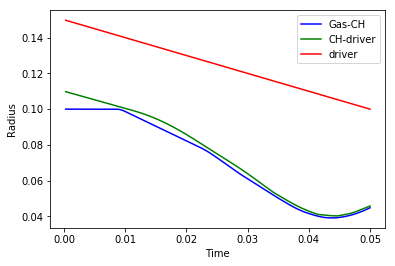

In [34]:
# Physics Loop
time = 0.0
cnt = 1


step = 0
CFL = 0.05
pt_gas = []
pt_ch  = []
pt_dr  = []
pt_time = []
while time < tf:
    
        # Adaptive time steps
        x    = hydro_state['x']
        xdot = hydro_state['xdot']
        cs   = np.sqrt(hydro_state['cs2'])
        dt   = CFL * np.min(np.diff(x) / ( np.abs(xdot[1:]) + cs + 1.0e-10 ) )
        
        hydroStep(dt, hydro_state)
        time += dt
        step += 1
        
        # Some edits
        if ( step % 50 == 0 ):
            # Save P-T data
            x_gas = hydro_state['x'][nz_gas]
            x_ch  = hydro_state['x'][nz_gas+nz_ch]
            x_dr  = hydro_state['x'][-1]

            pt_gas.append( x_gas )
            pt_ch.append( x_ch )
            pt_dr.append( x_dr )
            pt_time.append( time )

plt.plot( pt_time, pt_gas, 'b',label='Gas-CH')
plt.plot( pt_time, pt_ch, 'g',label='CH-driver')
plt.plot( pt_time, pt_dr, 'r',label='driver')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.legend()
plt.show()

In [35]:
# Compute convergence ratio (Vmax/Vmin)
print( (np.max(pt_gas)/ np.min(pt_gas))**3 )   # Should be ~16.6

16.608029362389168


The convergence ratio in the gas is ~16.6.  Now that we can implode a capsule, we need to start adding some more physics!


## Excercise 9: ICF multi-material implosion using LEOS

We repeat the previous excercise, only now we add realisitic material equations of state using the LEOS library.  For the purpose of this course, it's sufficient to know that LEOS provides tabular data and functions for a broad library of materials.  Generally, we have $V = f(\rho,T)$, where $V$ is a thermodynamically dependent variable on $\rho$ and $T$.

Our hydro code was written to solve for $\rho$ and $e$, therefore we'll need to use LEOS by doing an inverse lookup for temperature using energy, $T_{inv} = \hat{f}_e(\rho,e)$, and then solving for pressure, $p = f_p(\rho,T_{inv})$.

In the example below, we show how multiple material EOS's can be handled inside a general EOS function.  The problem from the previous excercise is identical, except for the material EOS, and the source drive.


In [36]:

# Setup 1D data
N = nz_gas + nz_ch + nz_dr
hydro_state = setupHydroState(N)
 
x_gas = np.linspace(0     , L_gas, nz_gas+1 )[:-1]
x_ch  = np.linspace(L_gas , L_ch , nz_ch +1 )[:-1]
x_dr  = np.linspace(L_ch  , L_dr , nz_dr +1 )

# Initialize the mesh and volumes
hydro_state['geom'] = geom
hydro_state['x'][:] = np.concatenate( (x_gas,x_ch,x_dr) )
updateVolume(hydro_state)

 
# Make material slices (like nodelists)
sl_gas = np.s_[:nz_gas]
sl_ch  = np.s_[nz_gas:nz_gas+nz_ch]
sl_dr  = np.s_[nz_gas+nz_ch:N]
sl_drN = np.s_[nz_gas+nz_ch:N+1]

    
# Tabular EOS
# Load common functions
sys.path.append("../../libEOS/python")
from libEOS import *

dt_eos = setupLEOS( 18 ,   ['Et','Pt','Cs'] )  # DT gas
ch_eos = setupLEOS( 790 ,  ['Et','Pt','Cs'] )  # Gold
dr_eos = setupLEOS( 360,   ['Et','Pt','Cs'] )  # Krypton

mats = {}
#  Material name -- zone list -- eos object 
mats['driver']  = [ sl_dr     ,  dr_eos  ]
mats['plastic'] = [ sl_ch     ,  ch_eos  ]
mats['gas']     = [ sl_gas    ,  dt_eos  ]


# All table model for the EOS
def eos(hd):
    '''EOS using LEOS tables for each material
    Note, this is implicitly capturing the global variable mats'''
    for mat in mats:
        sl  = mats[mat][0]   # Local slice for this material "mat"
        ieos = mats[mat][1]  # Local leos object/function for material "mat"

        # Find temperature first (inverse from energy)
        hd['T'][sl] = ieos['Et'].ieval( hd['den'][sl], hd['e'][sl] )
        
        # Get pressure using temp.
        hd['p'][sl] = ieos['Pt'].eval( hd['den'][sl], hd['T'][sl] )
        cs          = ieos['Cs'].eval( hd['den'][sl], hd['T'][sl] )
        
        # Compute the sound speed squared
        hd['cs2'][sl] = cs**2

hydro_state['eos'] = eos


# NIF capsule initial conditions
for mat in mats:
    sl  = mats[mat][0]
    ieos = mats[mat][1]
    hydro_state['den'][sl] = ieos['rho0']
    hydro_state['T'][sl]   = ieos['T0']

    Tinv =     hydro_state['T'][sl]
    hydro_state['p'][sl]  = ieos['Pt'].eval( hydro_state['den'][sl], Tinv )
    hydro_state['e'][sl]  = ieos['Et'].eval( hydro_state['den'][sl], Tinv )

# Update EOS
eos(hydro_state)
    
    
# driver
xdot_driver = -5.0 * numpy.sqrt( hydro_state['cs2'][sl_dr][0] ) # Mach 5 implosion velocity
hydro_state['e'][sl_dr] = 1.0e9                                 # Lots of energy in Krypton
hydro_state['xdot'][sl_drN] = xdot_driver

# Update EOS
eos(hydro_state)



tf = 1.5e-7
dt = 2.0e-6


# Get pressure and masses
eos(hydro_state)
updateMass(hydro_state)


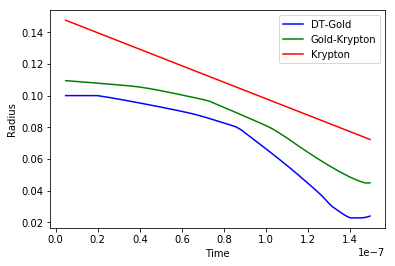

In [37]:
# Physics Loop
time = 0.0
cnt = 1


step = 0
CFL = 0.1
pt_gas = []
pt_ch  = []
pt_dr  = []
pt_time = []
while time < tf:
    
        # Adaptive time steps
        x    = hydro_state['x']
        xz   = hydro_state['xz']
        xdot = hydro_state['xdot']
        cs   = np.sqrt(hydro_state['cs2'])
        dt   = CFL * np.min(np.diff(x) / ( np.abs(xdot[1:]) + cs + 1.0e-10 ) )
        
        hydroStep(dt, hydro_state)
        time += dt
        step += 1
        
               
        # Some edits
        if ( step % 200 == 0 ):
            # Save P-T data
            x_gas = hydro_state['x'][nz_gas]
            x_ch  = hydro_state['x'][nz_gas+nz_ch]
            x_dr  = hydro_state['x'][-1]

            pt_gas.append( x_gas )
            pt_ch.append( x_ch )
            pt_dr.append( x_dr )
            pt_time.append( time )      


plt.figure()
plt.plot( pt_time, pt_gas, 'b',label='DT-Gold')
plt.plot( pt_time, pt_ch, 'g',label='Gold-Krypton')
plt.plot( pt_time, pt_dr, 'r',label='Krypton')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.legend()
plt.pause(.1)

In [38]:
# Compute convergence ratio (Vmax/Vmin)
print( (np.max(pt_gas)/ np.min(pt_gas))**3 )   # Should be ~83.99

83.9884043868844


## Final Step: Complete your module 

Congrats!  You've completed the libHydro module!  To finalize this module, copy and paste your final functions into:

`libHydro/python/libHydro_template.py`

and then rename the file:

`libHydro/python/libHydro.py`


This will allow future modules to use libHydro in a consistent manner as we build up our multi-physics capability.

#### Test your install

After you've installed `libHydro.py`, change the variable at the top of this file to:

```python
use_answer_key = True
libHydroFile = "../python/libHydro.py"
```

Then, select Kernel->Reset and Run All.  This will test your libHydro module.
If you see a plot at the end of excercise 9 and consistent convergence rate, you're done!

